In [1]:
import pyspark as ps
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import udf, array
from pyspark.sql.types import StringType
from pyspark.sql.functions import col
from pyspark.sql.functions import countDistinct

spark = (ps.sql.SparkSession.builder 
        .master("local[4]") 
        .appName("nathanscope") 
        .getOrCreate()
        )

In [2]:
sc = spark.sparkContext

In [3]:
# import the many data types
from pyspark.sql.types import *

# create a schema of your own
auth_schema = StructType( [
    StructField('time',     LongType(), True),
    StructField('src_user_domain',   StringType(),  True),
    StructField('dst_user_domain',   StringType(),  True),
    StructField('src_comp',   StringType(),  True),
    StructField('dst_comp',   StringType(),  True),
    StructField('auth_type',  StringType(), True),
    StructField('logon_type',  StringType(),  True),
    StructField('auth_orientation',  StringType(),  True),
    StructField('Success',  StringType(),  True)] )

proc_schema = StructType( [
    StructField('time',     LongType(), True),
    StructField('user_domain',   StringType(),  True),
    StructField('comp',   StringType(),  True),
    StructField('proc_name',   StringType(),  True),
    StructField('start',   StringType(),  True),
    ] )

flow_schema = StructType( [
    StructField('time',     LongType(), True),
    StructField('duration',     LongType(), True),
    StructField('src_comp',   StringType(),  True),
    StructField('src_port',   StringType(),  True),
    StructField('dst_comp',   StringType(),  True),
    StructField('dst_port',   StringType(),  True),
    StructField('protocol',  StringType(), True),
    StructField('pk_count',  LongType(),  True),
    StructField('byte_count',  LongType(),  True)] )

DNS_schema = StructType( [
    StructField('time',     LongType(), True),
    StructField('src_comp',   StringType(),  True),
    StructField('comp_resolved',   StringType(),  True),
    
    ] )


In [4]:
rdd_auth = (sc.pickleFile("Data/Day1/auth/part*")
            
           )

rdd_proc = (sc.pickleFile("Data/Day1/proc/part*")
            
           )

rdd_flow = (sc.pickleFile('Data/Day1/flow/part*')
           )

rdd_DNS = (sc.pickleFile("Data/Day1/DNS/part*")
           
           )

In [5]:
auth_df = spark.createDataFrame(rdd_auth,auth_schema)

proc_df = spark.createDataFrame(rdd_proc,proc_schema)

flow_df = spark.createDataFrame(rdd_flow,flow_schema)

DNS_df = spark.createDataFrame(rdd_DNS,DNS_schema)

In [6]:
active_comps_df = pd.read_csv('Summary/Day1/active_comps_df.csv')
active_user_df= pd.read_csv('Summary/Day1/active_users_df.csv')
active_red_team =pd.read_csv('Summary/Day1/active_red_team.csv')

In [7]:
active_red_team.head(15)

,Unnamed: 0,time,src_domain,src_comp,dst_comp
0,4,153792,U636@DOM1,C17693,C294
1,5,155219,U748@DOM1,C17693,C5693
2,39,483455,U1723@DOM1,C17693,C294
3,40,483981,U1723@DOM1,C17693,C294
4,41,485925,U1723@DOM1,C17693,C294
5,42,486443,U636@DOM1,C17693,C294
6,45,491747,U1723@DOM1,C17693,C294
7,79,736894,U2837@DOM1,C17693,C1484
8,166,755904,U162@DOM1,C17693,C798
9,168,757235,U737@DOM1,C17693,C1125


In [8]:
active_comps_df.columns = ['ignore','comp','count_user']

In [9]:
active_flow_df = flow_df.where(col("src_comp").isin(list(active_comps_df['comp'])) | col("dst_comp").isin(list(active_comps_df['comp'])))

In [10]:
add_download = udf(lambda x : 1 if x in list(active_comps_df['comp']) else 0 )
add_upload = udf(lambda x : 1 if x in list(active_comps_df['comp']) else 0 )
active_flow_df = active_flow_df.withColumn('Download', add_download(active_flow_df['dst_comp']))
active_flow_df = active_flow_df.withColumn('Upload', add_upload(active_flow_df['src_comp']))
flow_df = flow_df.withColumn('Download', add_download(flow_df['dst_comp']))
flow_df = flow_df.withColumn('Upload', add_upload(flow_df['src_comp']))

active_flow_df.agg({"Download":"sum"}).collect()

active_flow_df.agg({"Upload":"sum"}).collect()

active_flow_df.filter((col("Download")==1)&(col("Upload")==1)).count()

active_flow_df.count()

In [15]:
869528+915599

1785127

active_flow_df.agg(countDistinct("src_comp")).collect()

active_flow_df.agg(countDistinct("dst_comp")).collect()

In [18]:
active_upload_df = active_flow_df.filter("Upload = 1")
active_download_df = active_flow_df.filter("Download = 1")

### add upload and download bytes and packets

In [42]:
add_count = udf(lambda x : x[1] if x[0]=='1' else 0 )


In [43]:
active_flow_df = active_flow_df.withColumn('upload_bytes',add_count(array('Upload','byte_count')))
active_flow_df = active_flow_df.withColumn('download_bytes',add_count(array('Download','byte_count')))
active_flow_df = active_flow_df.withColumn('upload_pk',add_count(array('Upload','pk_count')))
active_flow_df = active_flow_df.withColumn('download_pk',add_count(array('Download','pk_count')))

In [ ]:
flow_df = flow_df.withColumn('upload_bytes',add_count(array('Upload','byte_count')))
flow_df = flow_df.withColumn('download_bytes',add_count(array('Download','byte_count')))
flow_df = flow_df.withColumn('upload_pk',add_count(array('Upload','pk_count')))
flow_df = flow_df.withColumn('download_pk',add_count(array('Download','pk_count')))

In [44]:
sample_user_flow_df = active_flow_df.filter("(Upload = 1 and src_comp = 'C2908') or (Download = 1 and dst_comp = 'C2908')")


In [45]:
active_flow_df.select('upload_bytes','download_bytes','upload_pk','download_pk','Upload','Download').show()

+------------+--------------+---------+-----------+------+--------+
|upload_bytes|download_bytes|upload_pk|download_pk|Upload|Download|
+------------+--------------+---------+-----------+------+--------+
|          60|             0|        1|          0|     1|       0|
|        3632|             0|        8|          0|     1|       0|
|           0|            60|        0|          1|     0|       1|
|           0|           120|        0|          2|     0|       1|
|           0|            48|        0|          1|     0|       1|
|           0|          2276|        0|         10|     0|       1|
|           0|          4128|        0|          7|     0|       1|
|          94|             0|        2|          0|     1|       0|
|        1223|             0|        6|          0|     1|       0|
|           0|          2073|        0|         13|     0|       1|
|        3307|             0|       11|          0|     1|       0|
|           0|          1234|        0|         

In [46]:
interval_size = 600

In [47]:
make_interval = udf(lambda x :  str((x//interval_size)*interval_size).zfill(7))

In [48]:

active_flow_df = active_flow_df.withColumn('interval', make_interval(sample_user_flow_df['time']))

In [49]:
flow_time_series = active_flow_df.groupBy('interval').agg({'duration': 'mean','pk_count':'sum','byte_count':'sum','upload_bytes':'sum','download_bytes':'sum','upload_pk':'sum','download_pk':'sum'}).collect()




In [50]:
flow_time_series_df = pd.DataFrame(flow_time_series)
flow_time_series_df.columns = ['time','mean_duration','pk_count','byte_count','upload_bytes','download_bytes','upload_pk','download_pk']



,Unnamed: 0,time,src_domain,src_comp,dst_comp
0,4,153792,U636@DOM1,C17693,C294
1,5,155219,U748@DOM1,C17693,C5693
2,39,483455,U1723@DOM1,C17693,C294
3,40,483981,U1723@DOM1,C17693,C294
4,41,485925,U1723@DOM1,C17693,C294
5,42,486443,U636@DOM1,C17693,C294
6,45,491747,U1723@DOM1,C17693,C294
7,79,736894,U2837@DOM1,C17693,C1484
8,166,755904,U162@DOM1,C17693,C798
9,168,757235,U737@DOM1,C17693,C1125


In [51]:
flow_time_series_df = flow_time_series_df.sort_values('time')

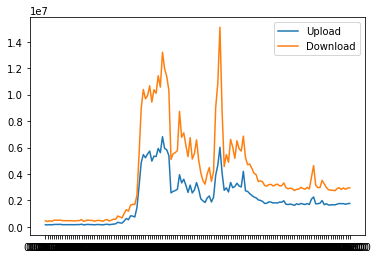

In [54]:
plt.plot(flow_time_series_df['time'],flow_time_series_df['upload_bytes'],label = 'Upload')
plt.plot(flow_time_series_df['time'],flow_time_series_df['download_bytes'],label = 'Download')
plt.legend()

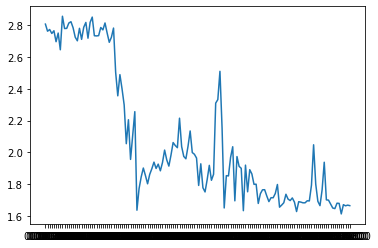

In [56]:
plt.plot(flow_time_series_df['time'],flow_time_series_df['download_bytes']/flow_time_series_df['upload_bytes'])

In [53]:
flow_time_series_df.head()

,time,mean_duration,pk_count,byte_count,upload_bytes,download_bytes,upload_pk,download_pk
88,0000000,9.542729,432894830,8835859.0,162617.0,456224,424058971.0,293607.0
134,0000600,10.578339,382590200,9592488.0,148626.0,410353,372997712.0,261727.0
17,0001200,11.428233,433856937,9535333.0,167561.0,464414,424321604.0,296853.0
42,0001800,10.763228,381259190,8914394.0,152485.0,418854,372344796.0,266369.0
65,0002400,8.033760,441083928,11008130.0,180554.0,499024,430075798.0,318470.0


# Look at known Redteam Traffic


In [61]:
active_red_team.head(20)

,Unnamed: 0,time,src_domain,src_comp,dst_comp
0,4,153792,U636@DOM1,C17693,C294
1,5,155219,U748@DOM1,C17693,C5693
2,39,483455,U1723@DOM1,C17693,C294
3,40,483981,U1723@DOM1,C17693,C294
4,41,485925,U1723@DOM1,C17693,C294
5,42,486443,U636@DOM1,C17693,C294
6,45,491747,U1723@DOM1,C17693,C294
7,79,736894,U2837@DOM1,C17693,C1484
8,166,755904,U162@DOM1,C17693,C798
9,168,757235,U737@DOM1,C17693,C1125


In [63]:
reds = ['C294','C5693']

In [66]:
red_flow_df =  active_flow_df.where(col("src_comp").isin(reds)|col("dst_comp").isin(reds))
red_time_series = red_flow_df.groupBy('interval').agg({'duration': 'mean','pk_count':'sum','byte_count':'sum','upload_bytes':'sum','download_bytes':'sum','upload_pk':'sum','download_pk':'sum'}).collect()

red_time_series_df = pd.DataFrame(red_time_series)
red_time_series_df.columns = ['time','mean_duration','pk_count','byte_count','upload_bytes','download_bytes','upload_pk','download_pk']




red_time_series_df

ValueError: Length mismatch: Expected axis has 0 elements, new values have 8 elements

In [67]:
red_time_series_df

""
